### Discussion:
 - The arguments `nshots` and `scalar_cost_function` default to `0` and `True` respectively, so they don't have to be passed explicitely. Do we pass them anyways, to indicate to the user that there are some more options, or do we remove them to get shorter and easier to understand code?
 - The argument `sim` is not neccesary anymore, if it is not passed `QAOACostFunctionOnWFSim` simply gets its own simulator connection. So the same question arises here again.
 - I found, that `Nelder-Mead` (the default for scipy.optimize.minimize) gets stuck in local minima quite often (at least with) the examples in `AdvancedQAOAParameterDemo` and I needed to pass `method="Cobyla"` often. Do we go with `Nelder-Mead` anyways, because the correct choice of an optimizer is a question that is more appropriate for the more advanced Notebooks?

# An example workflow of the QAOA package

This notebook walks through a simple example workflow, and is intended as a quick introduction to the functionalities of the package. More elaborate examples are provided in other notebooks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# import the neccesary pyquil modules
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.unitary_tools import lifted_pauli

# import the QAOAParameters that we want to demo
from entropica_qaoa.qaoa.parameters import (AbstractParams,
                                            StandardParams,
                                            ExtendedParams,
                                            QAOAParameterIterator)

# import VQE and cost function modules
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim

## Set up the problem hyperparameters

We start by setting up the Hamiltonian encoding the cost function we wish to minimise, as well as the timesteps to run QAOA. We do so by first using the `AbstractParams` class, however we could just as easily set up any specific parametrisation directly -- see the notebook `QAOAParameterDemo.ipynb` for more details. 

In [2]:
hamiltonian = []
hamiltonian.append(PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1))
hamiltonian.append(PauliTerm("Z", 0, 1.2)*PauliTerm("Z", 2))
hamiltonian.append(PauliTerm("Z", 0, -0.5))
hamiltonian = PauliSum(hamiltonian)
print("hamiltonian =", hamiltonian)

timesteps = 2
abstract_params = AbstractParams([hamiltonian,timesteps])
print(abstract_params)

hamiltonian = (0.7+0j)*Z0*Z1 + (1.2+0j)*Z0*Z2 + (-0.5+0j)*Z0
Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	single_qubit_coeffs: [-0.5]
	qubits_pairs: [[0, 1], [0, 2]]
	pair_qubit_coeffs: [0.7 1.2]
	n_steps: 2



## Specfify the variable parameters and create corresponding `QAOAParameters` object

Here we will set up `StandardParameters` - this corresponds to the parametrisation of the original QAOA paper by Farhi et al, where the mixer and cost Hamiltonian each have one angle per timestep (giving a total of 2p parameters to optimise over).

In [3]:
# Specify some angles
betas = [0.1, 0.6]
gammas = [0.4, 0.5]
parameters = (betas, gammas)

standard_params = StandardParams.from_AbstractParameters(abstract_params, parameters)
print(standard_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [0.1 0.6]
	gammas: [0.4 0.5]



## Set up the cost function and running the optimiser

For simplicity here, we will work on the wavefunction simulator, which requires opening the QVM and Quil Compiler.
Open two separate terminal windows, typing `qvm -S` in one, and `quilc -S` in the other. If you have installed the Forest SDK, the Quantum Virtual Machine will start in the background. More information on installing and running the QVM can be found in Rigetti's __[Forest documentation](http://docs.rigetti.com/en/stable/start.html)__. 

In [4]:
# Set up the WavefunctionSimulator object
sim = WavefunctionSimulator()

We now create the `cost_function` object, with all the necessary inputs. In the notebook `VQEDemo.ipynb` we give more detail and illustration of the uasge of the `scalar_cost_function`, `noisy` and `enable_logging` features; in this notebook, we will not make use of them.

In [5]:
# set up the cost function
cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params,
                                        sim=sim,
                                        scalar_cost_function=True, # See VQEDemo.ipynb for more details
                                        nshots=0,       # See VQEDemo.ipynb for more details
                                        enable_logging=False)

# and optimize the parameters
res = minimize(cost_function, standard_params.raw(), tol=1e-3,
                      options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.314241752490597
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 134
  status: 1
 success: True
       x: array([ 1.23855737,  0.28695087, -0.19301388,  0.58167549])

We can check this against the value we should get, by finding the lowest eigenvalue of `hamiltonian`.

In [6]:
ham_matrix = lifted_pauli(hamiltonian,hamiltonian.get_qubits())
eigs = np.linalg.eigvals(ham_matrix)
min(eigs)

(-2.4+0j)

Clearly we have not found the ground state energy. We can try increasing the number of timesteps:

In [7]:
betas          = [0.1, 0.6, 0.8]
gammas_singles = [0.4, 0.5, 0.6]
gammas_pairs   = [0.1, 0.3, 0.5]
parameters = (betas, gammas_singles, gammas_pairs)

standard_params_p3 = StandardParams([hamiltonian,3],parameters)

In [8]:
sim = WavefunctionSimulator()

cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params_p3,
                                        sim=sim,
                                        scalar_cost_function=True,
                                        nshots=0)

res = minimize(cost_function, standard_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.5996028753869584
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 91
  status: 1
 success: True
       x: array([0.53313931, 0.24934354, 1.48796382, 0.4948979 , 0.85173229,
       1.73626075])

This is better, but still not the actual ground state. Since we don't seem to be doing very well with `StandardParams`, let's try the `ExtendedParams` parametrisation instead.

In [9]:
extended_params_p3 = ExtendedParams.linear_ramp_from_hamiltonian(hamiltonian, n_steps=3)

cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=extended_params_p3,
                                        sim=sim,
                                        scalar_cost_function=True,
                                        nshots=0)

res = minimize(cost_function, extended_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500}, method="Cobyla")
res

     fun: -2.39998731995931
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 500
  status: 2
 success: False
       x: array([ 7.85900926e-01,  3.41615878e-01,  6.86391294e-01, -3.70906336e-05,
        7.70054041e-01,  2.85936757e-01,  3.91713648e-04, -5.98873628e-02,
        6.36408200e-01,  1.56419864e+00,  1.11530152e-01,  7.14734525e-02,
        1.52386651e-05, -4.87892239e-05,  1.20451190e+00,  2.38522673e-01,
        1.30958240e+00,  4.47177216e-01])

Clearly now we have found a much better ground state energy. The result attribute `x` is a list of the optimal circuit parameters that have been found. We can disentangle this into the `betas` and `gammas` of our QAOA parameterisation by using the `update_from_raw()` method:

In [10]:
extended_params_p3.update_from_raw(res['x'])
extended_params_p3

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [[ 7.85900926e-01  3.41615878e-01  6.86391294e-01], [-3.70906336e-05  7.70054041e-01  2.85936757e-01], [ 3.91713648e-04 -5.98873628e-02  6.36408200e-01]]
	gammas_singles: [[1.56419864], [0.11153015], [0.07147345]]
	gammas_pairs: [[ 1.52386651e-05 -4.87892239e-05], [ 1.20451190e+00  2.38522673e-01], [ 1.30958240e+00  4.47177216e-01]]

Now that we have the optimal angles, we can prepare the corresponding state and sample from it to obtain the most probable bitstring. 

In this notebook we are using the wavefunction simulator, which allows us to 'cheat' and easily obtain any observable quantity without the need to sample. We use the `get_wavefunction` method of the `cost_function` to obtain the wavefunction, then compute the corresponding probabilities, and plot a bar graph of the outcomes:

In [11]:
opt_wfn = cost_function.get_wavefunction(res.x)
print(opt_wfn)

(-1.126e-06-5.146e-07j)|000> + (-0.0014723985+0.0029947165j)|001> + (-2.33712e-05+0.0005113346j)|010> + (1.09157e-05-2.11459e-05j)|011> + (2.9239e-06+0.0002786279j)|100> + (-2.0329e-06-5.66462e-05j)|101> + (-0.4685439622+0.8834335914j)|110> + (-0.0003527883-0.0002023511j)|111>


In [12]:
probs = opt_wfn.probabilities()
probs

array([1.53266824e-12, 1.11362841e-05, 2.62009278e-07, 5.66299447e-10,
       7.76420291e-08, 3.21292867e-09, 9.99988355e-01, 1.65405532e-07])

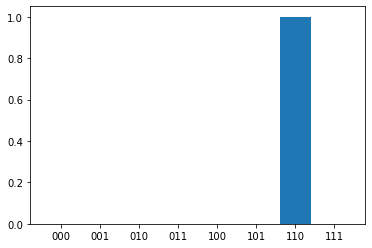

In [17]:
labels = ["{0:03b}".format(i) for i in range(8)]
plt.bar(range(8),probs)
plt.xticks(range(8), labels);

The QAOA has determined that the bitstring 110 (6 in decimal) is the minimum energy solution with essentially unit probability. Let's check this is consistent with the real answer:

In [14]:
np.linalg.eig(ham_matrix)

(array([ 1.4+0.j, -1.4+0.j,  0. +0.j,  0. +0.j, -1. +0.j,  1. +0.j,
        -2.4+0.j,  2.4+0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

The lowest energy solution does indeed correspond to the eigenvector $(0,0,0,0,0,0,1,0)$, i.e. the $|110\rangle$ component. Suppose that we return to the original Hamiltonian, but instead we remove the single-qubit bias term on qubit 0. Let's run the computation again and see what result we find.

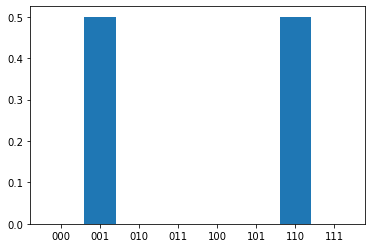

In [16]:
term1 = PauliTerm("Z", 0, 0.7) * PauliTerm("Z", 1)
term2 = PauliTerm("Z", 0, 1.2) * PauliTerm("Z", 2)

hamiltonian_unbiased = PauliSum([term1, term2])
n_steps = 2

params_unbiased = ExtendedParams.linear_ramp_from_hamiltonian(hamiltonian_unbiased,n_steps)

cost_function_unbiased = QAOACostFunctionOnWFSim(hamiltonian_unbiased,
                                                 params=params_unbiased,
                                                 sim=sim,
                                                 nshots=0)

res_unbiased = minimize(cost_function_unbiased, params_unbiased.raw(), tol=1e-3, options={"maxiter":500})

opt_wfn_unbiased = cost_function_unbiased.get_wavefunction(res_unbiased.x)
probs_unbiased = opt_wfn_unbiased.probabilities()

labels = ["{0:03b}".format(i) for i in range(8)]
plt.bar(range(8),probs_unbiased)
plt.xticks(range(8), labels);

Now the probabilities are completely symmetric under a bit flip on all qubits - there is no bias term in the Hamiltonian to force a given qubit into state $|0\rangle$ or $|1\rangle$, and the eigenspectrum of the cost function Hamiltonian is "doubly degenerate", i.e. the energy eigenstates fall into pairs, where the corresponding eigenstates are related to one another by a bit flip on all qubits. 